# General Sequence-to-Sequence Mappings

Many times, we want to map an arbitrary length sequence to another arbitrary length sequence for a machine learning task. The most common example would be for machine translation where the number of characters/words used to encode a sentence in one language rarely matches with the number of characters/works used to encode a sentence with the same meaning in another language. Thus, the many-to-many mapping used by the simple recurrent network used in the previous example will not be approprite.

In order to accomplish this task, the most common architecture used at this time is the *encoder-decoder* framework. First, we build an *encoder* network which takes an arbitrary length input sequence, and encodes a distributed representation of that input sequence using the hidden layer of a recurrent network. This is similar to a standard many-to-many recurrent network, except there is no output layer for the encoder. Instead, the input sequence information is simply folded into the hidden layer activation pattern at each time step. Once the encoder finishes generating a *gestalt* representation of the input sequence (using a recurrent hidden layer), the hidden layer activations are fed into a *decoder* network which translates the *gestalt* representation into the corresponding output sequence using another recurrent hidden layer and time-distributed output layer. Special *start* and *stop* patterns are used to encode for the starting and ending points of target sequences during training, so the *decoder* network learns to indicate when it is ready to start and finish a particular output sequence. Using its two subnetworks, the encoder-decoder framework forms a general sequence-to-sequence learning framework.

In order to illustrate how to build and train an encoder-decoder network, we will utilize the parity task from the simple recurrent network example. Even though the sequence lengths are the same for both the input and output for this task, we can still utilize it to illustrate the core concepts involved. Also, we will be using long short-term memory for the recurrent layers of these networks to show their effectiveness at learning these kinds of tasks.

In [1]:
# Import what we need for the job...
import keras

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras_tqdm import TQDMNotebookCallback

# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


Let's create the parity problem again, but we need to encode the input and target sequences a bit more generically this time to show how the process might be generalized to other types of sequence processing domains.

One key idea is that we need to map our possible sequence elements into a one-hot encoding dictionary which will be useful for arbitray sequence specification for both the encoder and decoder parts of the network. We will use the following mapping:

Input Sequences:

| Symbol | One-hot Encoding |
| --- | --- |
| `0` | `10` |
| `1` | `01` |

Ouput Sequences:

| Symbol | One-hot Encoding |
| --- | --- |
| `0` | `1000` |
| `1` | `0100` |
| start | `0010` |
| stop  | `0001` |

This encoding will necessarily make the problem easier to solve (0 is now mapped to a meaningful orthogonal dimension to the other symbols), but more importantly, it shows how each symbol in the input/output sequences needs an orthogonal dimension in the encoded form. Other distributed codes may also work, but high dot product similarity between vectors in the encoding chosen may affect the network's learning capabilities in unpredictable ways (more than likely negative). Also, it should be clear here that we don't even need to have the same *symbols* in the encoder and decoder networks. They can be arbitrary mappings in both time and space, which makes this a powerful, flexible approach.

OK, so let's generate a large set of training and testing sequences for the network to experience on this task...

In [18]:
# Length of sequences to model
length = 10

# Note we are making these the same, but they don't -have- to be!
input_length = length
output_length = length

As a good rule of thumb, we just want to create a network and train it to learn just a single example first. After that, we can extend it to a larger data set.

In [19]:
# Generate a random string of 0s and 1s
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]])

In [20]:
# Calculate parity (note this is the same algorithmic approach
# that we are trying to encourage our net to learn!)
def parity(x):
    temp = np.zeros(x.shape)
    mem = False
    # Iterate over the sequence
    for i in range(x.shape[0]):
        if x[i,0] > 0.5:
            current = True
        else:
            current= False
        mem = np.logical_xor(mem,current)
        if mem:
            temp[i,0] = 1.0
        else:
            temp[i,0] = 0.0
    return (temp.reshape(1,temp.shape[0],temp.shape[1])) # Tensor!

In [21]:
y_train = parity(x_train[0,:,:])
y_train

array([[[ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]])

Let's turn these into a set of encoded input-output vectors using the transformation above.

In [22]:
X = np.expand_dims(keras.utils.to_categorical(x_train[0,:,0]),axis=0)
X

array([[[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]])

In [26]:
Y = np.expand_dims(np.vstack([np.array([0,0,1,0]),
                   np.hstack([keras.utils.to_categorical(y_train[0,:,0]),np.zeros([input_length,2])]),
                   np.array([0,0,0,1])]),axis=0)
Y

array([[[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]]])

Also, note the shapes of the sequences...

In [29]:
X.shape

(1, 10, 2)

In [30]:
Y.shape

(1, 12, 4)

We will need to divide the target data into two groups which correspond to the input-target pairs for the *decoder* network. In essence, the decoder network is really just a many-to-many recurrent network, and will be trying to predict the next part of the target sequence (`postY`) given *both* the encoder output representation *and* the previous target sequence entry (`preY`). This previous target sequence entry is not strictly necessary, but using it represents a training strategy called *teacher forcing* which makes it easier to learn some sequences.

In [34]:
# 12 time steps total (10 + start + stop)
# Divide into two groups of 11
# First from 0 ... 10
preY = Y[:,1:output_length+2,:]
# Second from 1 ... 11
postY = Y[:,0:output_length+1,:]

In [42]:
preY.shape

(1, 11, 4)

In [43]:
postY.shape

(1, 11, 4)

OK, let's make an encoder-decoder framework for learning this sequence. We need to use the Keras *functional* API for building this network as well. To create networks of this kind, we first create `layer` objects and then call their `()` functions to make them take inputs from the provided layers' outputs. This allows for networks to receieve input from more than one layer at a time, or pass their outputs to more than one layer at a time. Once all of the layers have been connected in the desired ways, then we create a `Model` object which is provided a set of input and output layers for the overall model. This allows for more general network topologies to be constructed than can be achieved with the *sequential* API.

In [44]:
# Size of the gestalt, context representations...
encoder_hidden_size = input_length*2
decoder_hidden_size = output_length*2

## Encoder Construction

# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(encoder_hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]

## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, Y.shape[2]))
decoder_hidden = keras.layers.LSTM(decoder_hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_output, dec_state_h, dec_state_c = decoder_hidden(decoder_input,
                                                          initial_state=encoder_states)
decoder_dense = keras.layers.Dense(Y.shape[2], activation='softmax')
# Connect output to hidden
decoder_outputs = decoder_dense(decoder_output)

# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postYY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, 2)      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 20), (None,  1840        input_11[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, None, 20), ( 2000        input_12[0][0]                   
                                                                 lstm_10[0][1]                    
          

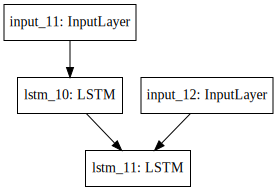

In [45]:
# Visualization - wish we could see the recurrent weights!
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [33]:
postY.shape

(1, 11, 4)